In [46]:
import os
from PIL import Image  # For image processing
import numpy as np  # For numerical operations
import pandas as pd 
import matplotlib.pyplot as plt    
import seaborn as sns
import random 
import cv2
import glob
from numpy.random import seed
seed(42)
random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

In [13]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [22]:
# Path to the dataset in Kaggle
dataset_path = '/kaggle/input/labeled-chest-xray-images/chest_xray/'

#Load train and test dataset
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

# Check if the dataset path exists
if os.path.exists(train_path) and os.path.exists(test_path):
    print("Dataset found! Train and Test sets are available. Proceeding with preprocessing...")

    #Check the number of images in train and test data
    num_train_images = sum([len(files) for _, _, files in os.walk(train_path)])
    num_test_images = sum([len(files) for _, _, files in os.walk(test_path)])
    
    print(f"number of train images: {num_train_images}")
    print(f"number of test images: {num_test_images}")
    
else:
    if not os.path.exists(train_path):
        print(f"Train dataset not found at {train_path}. Please check the folder structure.")
    if not os.path.exists(test_path):
        print(f"Test dataset not found at {test_path}. Please check the folder structure.")

Dataset found! Train and Test sets are available. Proceeding with preprocessing...
number of train images: 5232
number of test images: 624


In [15]:
# Function to check the number of images in each category
def count_images_per_class(data_path):
    class_counts = {}
    
    for root, _, files in os.walk(data_path):
        if root == data_path:
            continue  

        class_name = os.path.basename(root)  
        num_images = len(files)  
        class_counts[class_name] = num_images 
    
    return class_counts

In [16]:
train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

print("Number of images for each class (Train):")
for class_name, count in train_counts.items():
    print(f" {class_name}: {count}")

print("Number of images for each class (Test):")
for class_name, count in test_counts.items():
    print(f" {class_name}: {count}")

Number of images for each class (Train):
 PNEUMONIA: 3883
 NORMAL: 1349
Number of images for each class (Test):
 PNEUMONIA: 390
 NORMAL: 234


There is a large difference between the number of images in the pneumonia and normal categories, leading to imbalanced data.

In [6]:
# List all files and folders in the dataset
#for dirname, _, filenames in os.walk(dataset_path):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [17]:
# Directory to save resized images
output_path = '/kaggle/working/preprocessed_images'
os.makedirs(output_path, exist_ok=True)

In [18]:
dataset_paths = {'train': train_path, 'test': test_path}

for dataset_type, dataset_path in dataset_paths.items():
    for class_name in os.listdir(dataset_path):  
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_path):
            continue
        

        output_class_path = os.path.join(output_path, dataset_type, class_name)
        os.makedirs(output_class_path, exist_ok=True)

In [19]:
# Function to check if an image is corrupted
def is_image_corrupted(img_path):
    try:
        img = Image.open(img_path)
        img.verify()  # Verifies if an image is corrupted
        return False  # No error, so it's not corrupted
    except (IOError, SyntaxError) as e:
        return True  # Corrupted image

In [20]:
datasets_paths = [train_path, test_path]
corrupted_images = []

for dataset_path in datasets_paths:
    print(f"\n Searching for corrupted images in: {dataset_path}")
    
    for class_folder in os.listdir(dataset_path):  # Normal, Pneumonia
        class_path = os.path.join(dataset_path, class_folder)
        
        if os.path.isdir(class_path):  # Ensure that it is a folder, not a file
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if is_image_corrupted(img_path):
                    print(f"corrupted image: {img_path}")
                    corrupted_images.append(img_path)

# the number of corrupted images
print(f"\n The number of corrupted images in train and test: {len(corrupted_images)}")


 Searching for corrupted images in: /kaggle/input/labeled-chest-xray-images/chest_xray/train

 Searching for corrupted images in: /kaggle/input/labeled-chest-xray-images/chest_xray/test

 The number of corrupted images in train and test: 0


In [24]:
for dataset_type, dataset_path in dataset_paths.items():
    for class_name in os.listdir(dataset_path):  # (Normal/Pneumonia)
        class_path = os.path.join(dataset_path, class_name)
        
        if not os.path.isdir(class_path):  
            continue
        
        output_class_path = os.path.join(output_path, dataset_type, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for filename in os.listdir(class_path):  
            if filename.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(class_path, filename)
                
                if is_image_corrupted(img_path):
                    print(f"Skipping corrupted image: {filename}")
                    continue

                try:
                    img = Image.open(img_path)
                   
                    img_resized = img.resize((128, 128))
                    
                    img_array = np.array(img_resized) / 255.0

                    if img_array.shape[0] < 128 or img_array.shape[1] < 128:
                        print(f"Skipping low-quality image (too small): {filename}")
                        continue

                    output_file = os.path.join(output_class_path, filename)
                    img_normalized = Image.fromarray((img_array * 255).astype(np.uint8))
                    img_normalized.save(output_file)
                    #print(f"Processed and saved: {output_file}")

                except Exception as e:
                    print(f"Error processing {filename}: {e}")

print("Processing complete!")

Processing complete!


show information about this data

In [25]:
# Augmentation for balancing
print("Starting data augmentation...")
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

Starting data augmentation...


In [26]:
train_path = '/kaggle/working/preprocessed_images/train' 
normal_path = os.path.join(train_path, 'NORMAL')
pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

num_normal = len(os.listdir(normal_path))
num_pneumonia = len(os.listdir(pneumonia_path))

print(f" Normal={num_normal}, Pneumonia={num_pneumonia}")

 Normal=1349, Pneumonia=3883


In [28]:
normal_images = []
for img_name in os.listdir(normal_path):
    img_path = os.path.join(normal_path, img_name)
    img = load_img(img_path) 
    img_array = img_to_array(img) 
    normal_images.append(img_array)
    
normal_images = np.array(normal_images)

In [29]:
#num_augmentations = 3888 - 1340 
#augmented_images = []
#for _ in range(num_augmentations // 32):  
    #augmented_images.append(augmented_data.next())

num_augmentations = num_pneumonia - num_normal
augmented_images = []
datagen_flow = datagen.flow(normal_images, batch_size=32, shuffle=True)
    
for _ in range(num_augmentations // 32 + 1):
    augmented_images.extend(next(datagen_flow)) 
    if len(augmented_images) >= num_augmentations:
        break

In [17]:
#augmented_data = datagen.flow(normal_images, batch_size=32, shuffle=True)

In [30]:
#augmented_images = np.vstack(augmented_images)
augmented_images = np.array(augmented_images[:num_augmentations])

In [31]:
#train_images_balanced = np.concatenate([train_images, augmented_images], axis=0)
#train_labels_balanced = np.concatenate([train_labels, np.array(["NORMAL"] * len(augmented_images))], axis=0)
train_images_balanced = np.concatenate([normal_images, augmented_images], axis=0)
train_labels_balanced = np.array(["NORMAL"] * len(train_images_balanced))

In [32]:
print(f"Balanced dataset: Normal={len(train_images_balanced)}, Pneumonia={num_pneumonia}")

Balanced dataset: Normal=3882, Pneumonia=3883


In [33]:
# Function to prepare DataFrame 
def prepare_dataframe(dataset_path):
    image_paths = []
    classes = []

    for class_name in os.listdir(dataset_path):  # NORMAL, PNEUMONIA
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):  # Ensure it's a folder
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                image_paths.append(img_path)
                classes.append(class_name)

    # Create and return DataFrame
    return pd.DataFrame({
        "class": classes,
        "image": image_paths
    })

# Paths to dataset
train_path = '/kaggle/input/labeled-chest-xray-images/chest_xray/train'
test_path = '/kaggle/input/labeled-chest-xray-images/chest_xray/test'

# Prepare DataFrames
df_train = prepare_dataframe(train_path)
df_test = prepare_dataframe(test_path)


# Display DataFrames
print("Train DataFrame:")
print(df_train.head())
print("\nTest DataFrame:")
print(df_test.head())

Train DataFrame:
       class                                              image
0  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
1  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
2  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
3  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
4  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...

Test DataFrame:
       class                                              image
0  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
1  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
2  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
3  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...
4  PNEUMONIA  /kaggle/input/labeled-chest-xray-images/chest_...


Exploring The Data 

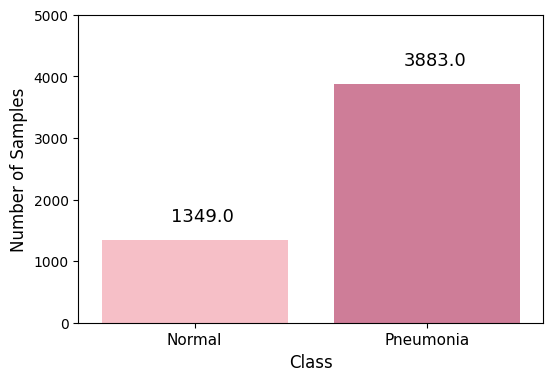

In [60]:
plt.figure(figsize=(6,4))

axis = sns.countplot(x='class', data=df_train, palette=["#FFB6C1", "#DB7093"])

plt.xlabel("Class", fontsize= 12)
plt.ylabel("Number of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in axis.patches:
    axis.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()


In [35]:
print(df_train['class'].value_counts())


class
PNEUMONIA    3883
NORMAL       1349
Name: count, dtype: int64


In [47]:
train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [48]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

Train Set - Normal


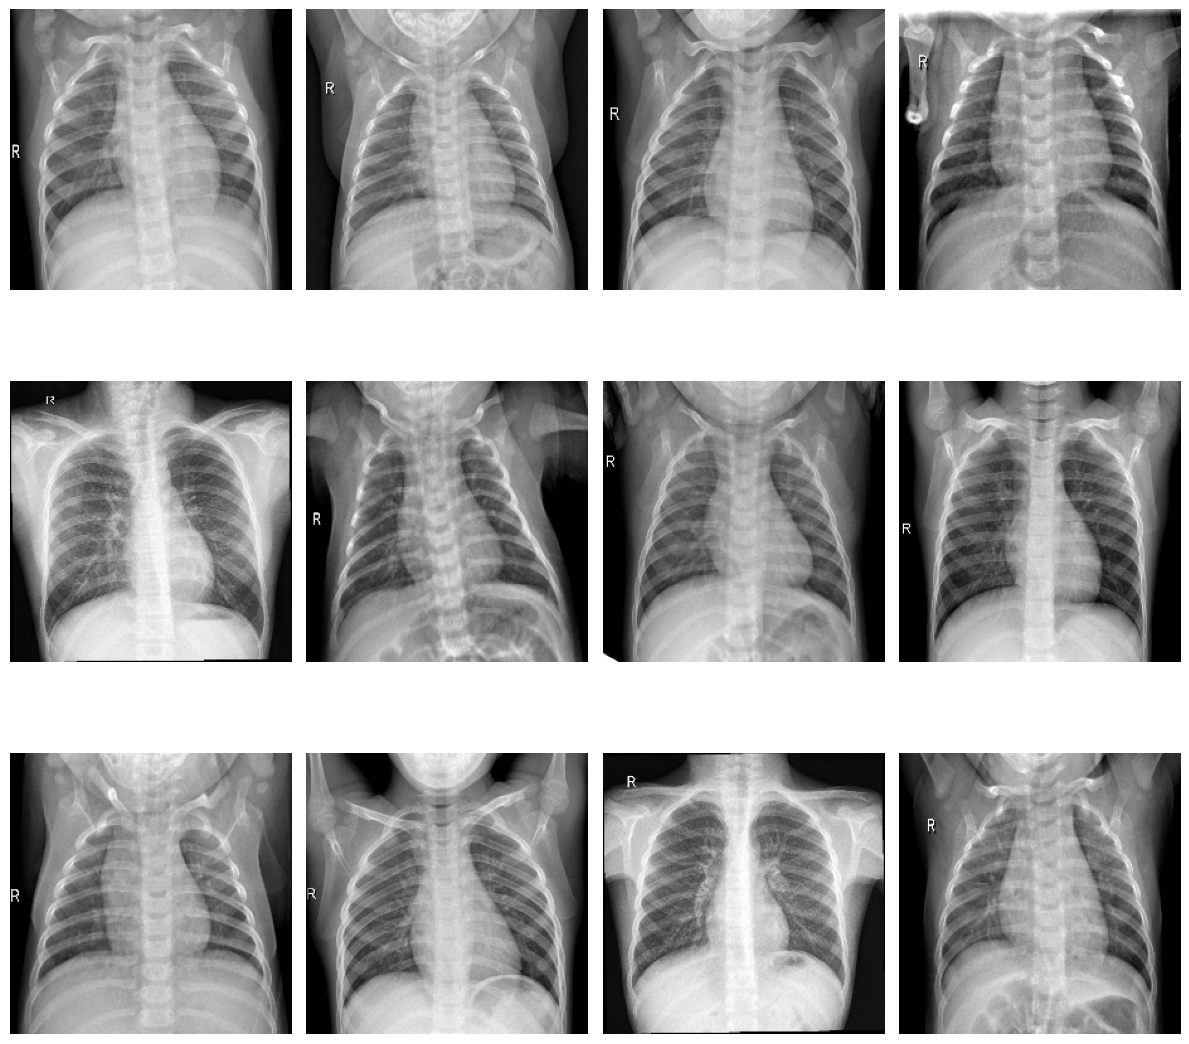

In [53]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


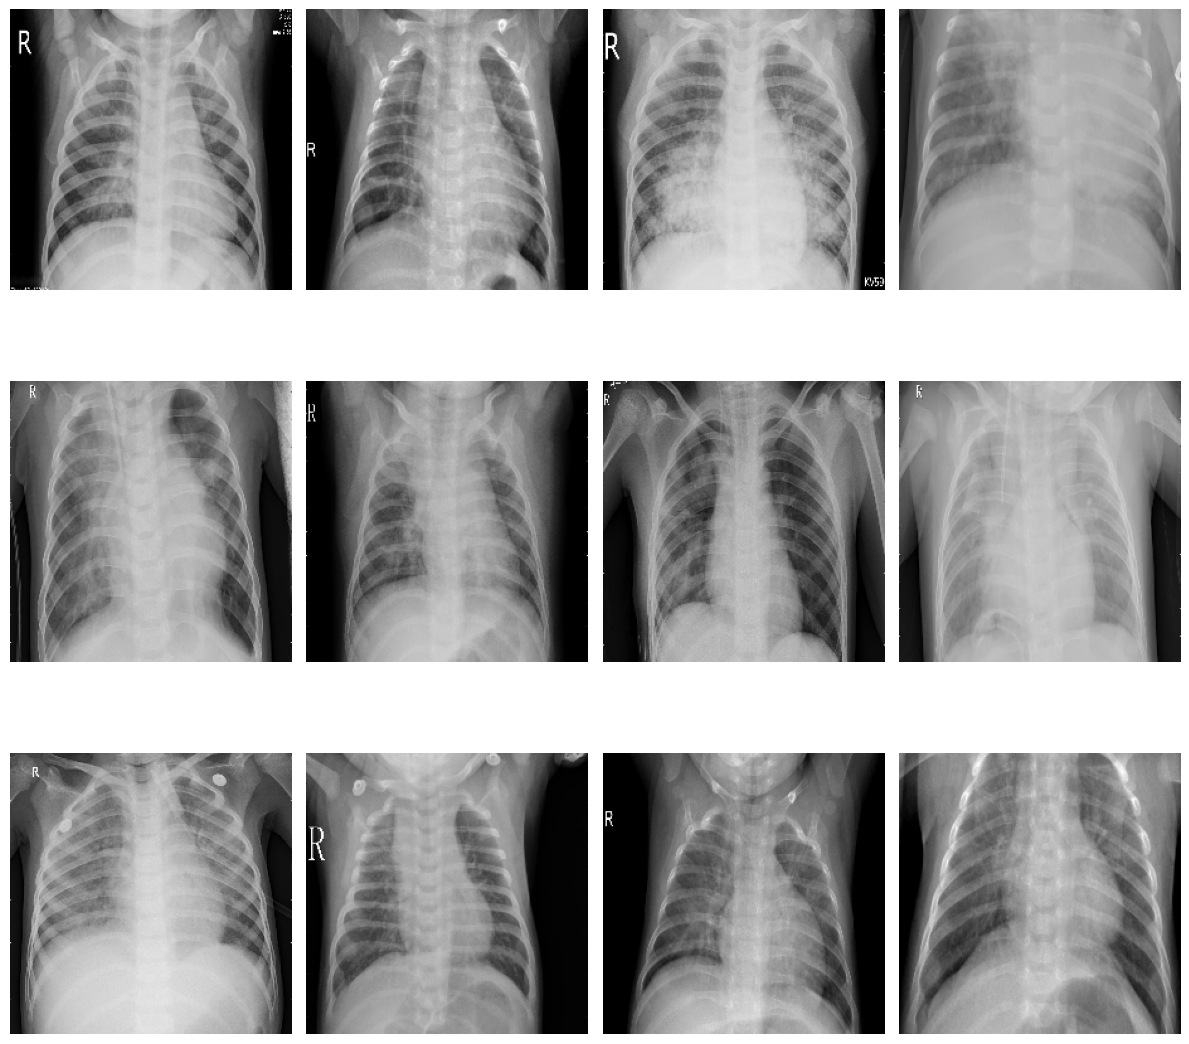

In [52]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


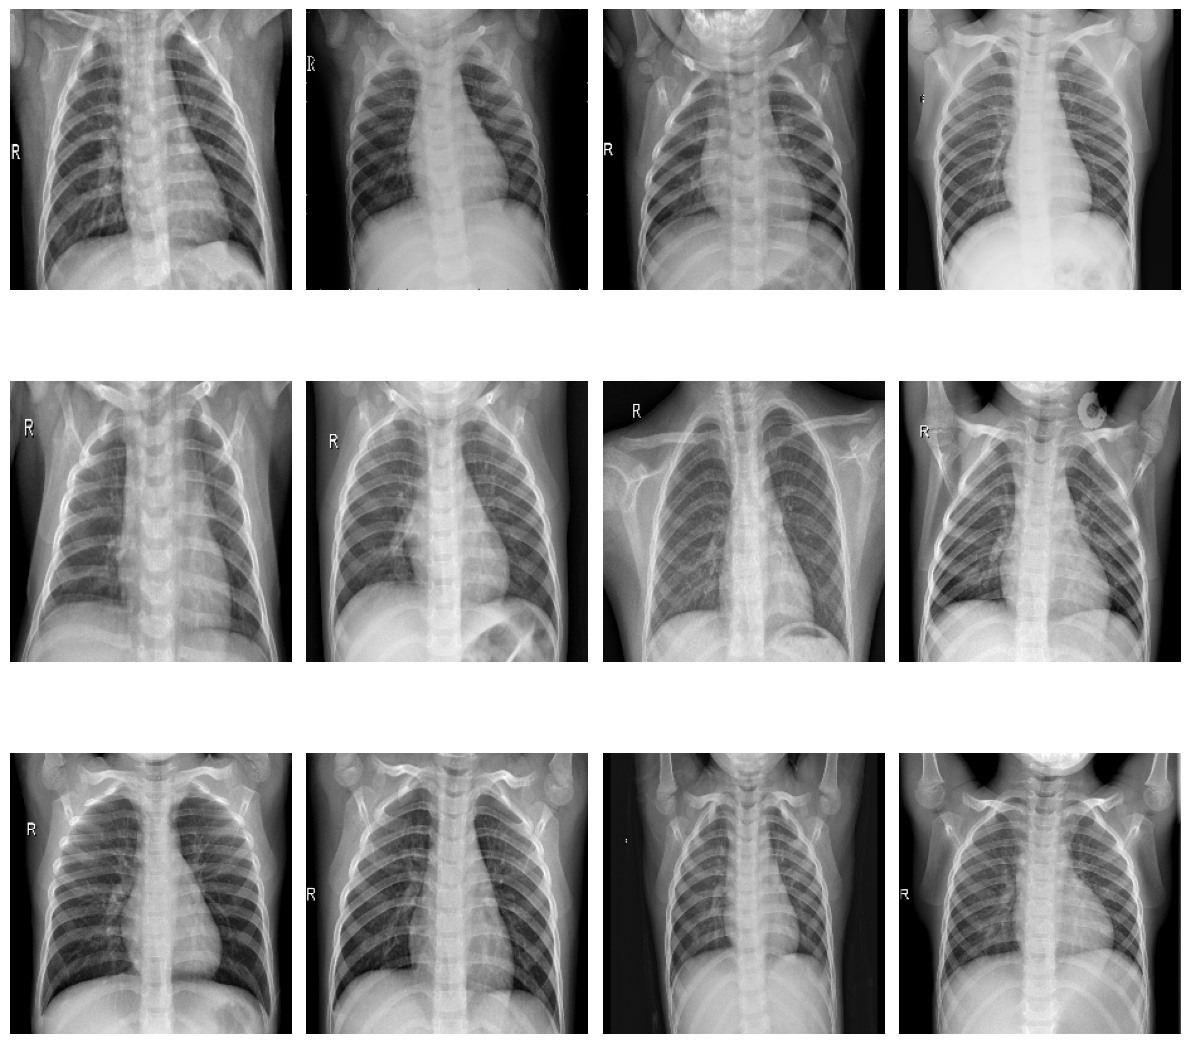

In [62]:
print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


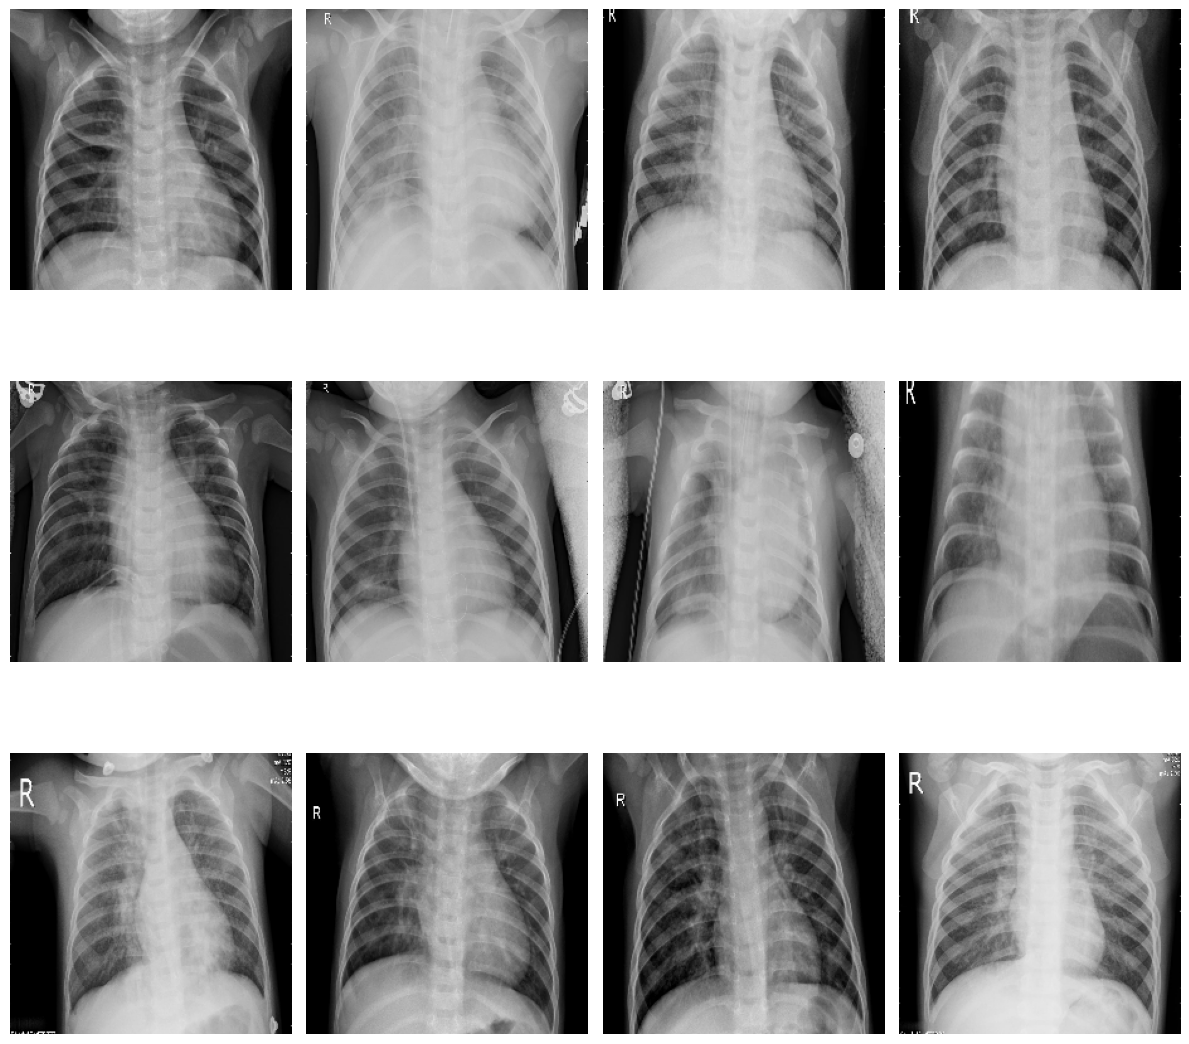

In [63]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()